# <font color='red'>**Transformer implementation**</font>

<font color='blue'>**Load the data**</font>

In [1]:
!pip install -q tfds-nightly

     |████████████████████████████████| 4.3 MB 7.7 MB/s 
     |████████████████████████████████| 98 kB 7.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9,.?! ]+', '', text)
    text = text.split()
    text = " ".join(text)
    return text

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle
data = pickle.load(open('/content/drive/MyDrive/Case Study2/data','rb'))

In [6]:
data

,enc_gen,enc_inp,dec_inp,dec_gen
0,f,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,...",m
1,m,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,f
2,f,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,m
3,f,You're asking me out. That's so cute. What's ...,Forget it.,m
4,f,"No, no, it's my fault -- we didn't have a prop...",Cameron.,m
...,...,...,...,...
221611,gender,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...,gender
221612,gender,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...,gender
221613,gender,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...,gender
221614,gender,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob...",gender


In [7]:
#Preprocessing the Data dataframe
data['enc_inp'] = data['enc_inp'].apply(preprocess)
data['dec_inp'] = data['dec_inp'].apply(preprocess)
data.head()

,enc_gen,enc_inp,dec_inp,dec_gen
0,f,can we make this quick? roxanne korrine and an...,"well, i thought we would start with pronunciat...",m
1,m,"well, i thought we would start with pronunciat...",not the hacking and gagging and spitting part....,f
2,f,not the hacking and gagging and spitting part....,okay... then how bout we try out some french c...,m
3,f,you are asking me out. that is so cute. what i...,forget it.,m
4,f,"no, no, it is my fault we did not have a prope...",cameron.,m


In [8]:
import tensorflow_datasets as tfds

In [10]:
data.dec_inp.values

array(['not the hacking and gagging and spitting part. please.',
       'okay... then how bout we try out some french cuisine. saturday? night?',
       'let me see what i can do.', ...,
       'good ones, yes, mr vereker. gentlemen who can ride and shoot',
       'i am to take the sikali with the main column to the river',
       'lord chelmsford seems to want me to stay back with my basutos.'],
      dtype=object)

In [9]:
# Tokenization

#https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data.enc_inp.values + data.dec_inp.values , target_vocab_size=2**13) # 2^13 ~ 8000 words

In [10]:
# Functions used later as in "train_examples.map(tf_encode)"



# encode function is use by tf_encode

# Add [CLS] and [SEP] and encode tokens for pt and en
MAX_LENGTH = 40

def encode(lang1, lang2):

  enc_token = []
  dec_token = []

  for (i,j) in zip(lang1, lang2):

    lang1 = [tokenizer.vocab_size] + tokenizer.encode(i) + [tokenizer.vocab_size+1]

    lang2 = [tokenizer.vocab_size] + tokenizer.encode(j) + [tokenizer.vocab_size+1]
    
    if len(lang1) <= MAX_LENGTH and len(lang2) <= MAX_LENGTH: 
      enc_token.append(lang1)
      dec_token.append(lang2)
    
  enc_token = tf.keras.preprocessing.sequence.pad_sequences(enc_token, maxlen = MAX_LENGTH, padding='post')

  dec_token = tf.keras.preprocessing.sequence.pad_sequences(dec_token, maxlen = MAX_LENGTH, padding='post')

  
  return enc_token, dec_token

In [11]:
#Splitting data into train and validation 
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [15]:
#pickle.dump((train, validation),open('/content/drive/MyDrive/Case Study2/data_split.pkl','wb'))

In [12]:
train_enc, train_dec = encode(train.enc_inp, train.dec_inp)

In [42]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets

BUFFER_SIZE = 20000
BATCH_SIZE = 512


dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_enc,
        'dec_inputs': train_dec[:, :-1]
    },
    {
        'outputs': train_dec[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [43]:
#train.enc_inp = train.enc_inp.apply(strip_gender)
#validation.enc_inp = validation.enc_inp.apply(strip_gender)
next(iter(dataset))

({'dec_inputs': <tf.Tensor: shape=(512, 39), dtype=int32, numpy=
  array([[8232,   66,    1, ...,    0,    0,    0],
         [8232,   12,    9, ...,    0,    0,    0],
         [8232,   98,    1, ...,    0,    0,    0],
         ...,
         [8232,    5, 3323, ...,    0,    0,    0],
         [8232,   10,    6, ...,    0,    0,    0],
         [8232,   20,    6, ...,    0,    0,    0]], dtype=int32)>,
  'inputs': <tf.Tensor: shape=(512, 40), dtype=int32, numpy=
  array([[8232,   54,   12, ...,    0,    0,    0],
         [8232,   17,    4, ...,    0,    0,    0],
         [8232,   53,    2, ...,    0,    0,    0],
         ...,
         [8232,   30, 1017, ...,    0,    0,    0],
         [8232,   54,   78, ...,    0,    0,    0],
         [8232,  474,   12, ...,    0,    0,    0]], dtype=int32)>},
 {'outputs': <tf.Tensor: shape=(512, 39), dtype=int32, numpy=
  array([[  66,    1,    3, ...,    0,    0,    0],
         [  12,    9,   31, ...,    0,    0,    0],
         [  98,    1,  

## <font color='blue'>**Positional Encoder**</font>

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
from  tensorflow.keras.layers import LSTM, Embedding, Dense, BatchNormalization

In [16]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


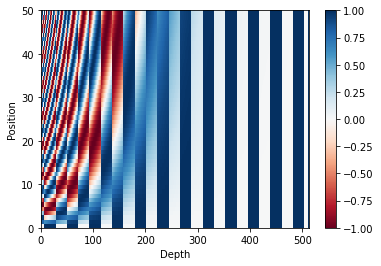

In [18]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<font color='blue'>**Masking**</font>

In [19]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [91]:
'''def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)'''

'def create_look_ahead_mask(size):\n  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)\n  return mask  # (seq_len, seq_len)'

In [20]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [22]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [24]:
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask zero out padding tokens.
  if mask is not None:
    logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(logits, axis=-1)

  return tf.matmul(attention_weights, value)

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

In [26]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [27]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [29]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

      #1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:

# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 512
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40



In [34]:
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [21]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [36]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  accuracy = tf.metrics.SparseCategoricalAccuracy()(y_true, y_pred)
  return accuracy



In [39]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model 

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3162112     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [44]:
model.fit(dataset, epochs= 50)

Epoch 1/50
304/304 [==============================] - 72s 238ms/step - loss: 1.5191 - accuracy: 0.0786
Epoch 2/50
304/304 [==============================] - 72s 236ms/step - loss: 1.4140 - accuracy: 0.0856
Epoch 3/50
304/304 [==============================] - 72s 237ms/step - loss: 1.3542 - accuracy: 0.0900
Epoch 4/50
304/304 [==============================] - 72s 236ms/step - loss: 1.3047 - accuracy: 0.0938
Epoch 5/50
304/304 [==============================] - 72s 236ms/step - loss: 1.2619 - accuracy: 0.0970
Epoch 6/50
304/304 [==============================] - 72s 236ms/step - loss: 1.2253 - accuracy: 0.0997
Epoch 7/50
304/304 [==============================] - 72s 236ms/step - loss: 1.1934 - accuracy: 0.1021
Epoch 8/50
304/304 [==============================] - 72s 236ms/step - loss: 1.1647 - accuracy: 0.1044
Epoch 9/50
304/304 [==============================] - 72s 236ms/step - loss: 1.1379 - accuracy: 0.1064
Epoch 10/50
304/304 [==============================] - 72s 236ms/step - l

In [45]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [46]:
def evaluate(sentence):
  sentence = preprocess(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence




In [76]:
model.save_weights('./checkpoints/my_checkpoint')

In [57]:
output = predict('I love you')

Input: I love you
Output: i love you, too.


In [61]:
output = predict('go to heaven')

Input: go to heaven
Output: i do not mind the conversations. i will be all right.


In [50]:
output = predict('go to school with mom')

Input: go to school with mom
Output: i will go with you, dad.


In [62]:
output = predict('good night dear')

Input: good night dear
Output: good night, honey.


In [65]:
output = predict('would you like a dinner with me')

Input: would you like a dinner with me
Output: i guess i can not just get off my property.


In [70]:
output = predict('what do you mean')

Input: what do you mean
Output: i know what you mean. i am not a guy.


In [48]:
output = predict('how are you')

Input: how are you
Output: i am fine. i am fine.


In [49]:
output = predict('idiot')

Input: idiot
Output: i will be right back.


In [52]:
# feed the model with its previous output
sentence = 'go to school with mom'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: go to school with mom
Output: i will go with you, dad.

Input: i will go with you, dad.
Output: i will be right back.

Input: i will be right back.
Output: i will take you home.

Input: i will take you home.
Output: i am not going to let you leave.

Input: i am not going to let you leave.
Output: no, i am not.



In [74]:
# feed the model with its previous output
sentence = 'get out !'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: get out !
Output: i am going to buy them

Input: i am going to buy them
Output: you are going to buy a new place, you can not get the money.

Input: you are going to buy a new place, you can not get the money.
Output: i am not going to have to get out of here.

Input: i am not going to have to get out of here.
Output: i am going to have to go home.

Input: i am going to have to go home.
Output: i am going to see you tomorrow.

